This file will serve as a proof of concept for everything I need to do for the first 3 lessons of: https://florianmarquardt.github.io/MachineLearningThreeEasyLessons/2024_09_MinimizeEnergy.html. The goal is to first replicate the code and results, then expand a bit on lesson 3


### Lesson 1
#### Basics of Optimization Using Machine Learning 

The first lesson is regarding Optimization using machine learning algorithms and jax. A chain is modelled as a series of masses with springs between them and the minimum energy state of the system is attempted to be found. The springs all have a constant of K and a free length of l. There is a 1 unit horizontal gap between any two masses. Using these facts, the potential energy of any given spring between two consecutive masses can be derrived as:

\begin{equation}
E_{spring} = \frac{K}{2}\left( \sqrt{\, (y_{i+1}-y_{i})^2 + 1^2 \,} - l \right)^2
\tag{1}
\end{equation}

It stands to reason then the total potential energy of all springs is going to be:

\begin{equation}
E_{total, springs} = \sum\limits_{i=0}^{N-1} \frac{K}{2}\left( \sqrt{\, (y_{i+1}-y_{i})^2 + 1^2 \,} - l \right)^2
\tag{2}
\end{equation}

Finally, we also consider the potential energy of all the masses:

\begin{equation}
E_{grav} = \sum\limits_{i=0}^N mgy_i
\tag{3}
\end{equation}

where m is the mass of any given link and g is the gravitational constant

In [1]:
from matplotlib import pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format='retina'

import jax.numpy as jnp
from jax import grad

In [2]:
def E(y, spring, length, mass_g):
    """
    This function computes the total energy of the system.
    y: array containing the positions of the masses
    spring: spring constant
    length: free length of the spring
    mass_g: mass of any given weight times the gravitational acceleration
    """

    spring_energy = jnp.sum(0.5 * spring * (jnp.sqrt((y[1:]-y[:-1])**2 + 1) - length)**2)
    # also add the boundary conditions
    spring_energy += 0.5 * spring * (jnp.sqrt(y[0]**2 + 1) - length)**2
    spring_energy += 0.5 * spring * (jnp.sqrt((y[-1])**2 + 1) - length)**2
    #also add the gravitation potential energy
    gravitational_energy = mass_g * jnp.sum(y)

    total_energy = spring_energy + gravitational_energy

    return total_energy



Now use jax to compute the gradient of the energy function. The minimum energy (i.e. the 0 gradient) is going to result in the equlibrium state of the masses

In [3]:
# Produce the function that calculates the gradient of E
# with respect to the y argument (argument number 0):

grad_E = grad(E, argnums = 0)

Now we want to use gradient descent to find the minimum. Gradient descent is effectivley a manual, looped way of 0ing in on the minima or maxima of a function. You take a step size, $\eta$ and you define a total number of steps $n_{steps}$ and you manually subtract the gradient from the potential and record the lowest value. So first set up the constants, then set up the loop

In [4]:
# Physics parameters:
N = 20 # number of masses in the chain
spring = 5.0 # spring constant
length = 0.5 # springs are stretched even when chain is straight!
mass_g = 0.1 # m*g for each mass

# Initialization:
y = jnp.zeros(N) # initially, all masses at y=0

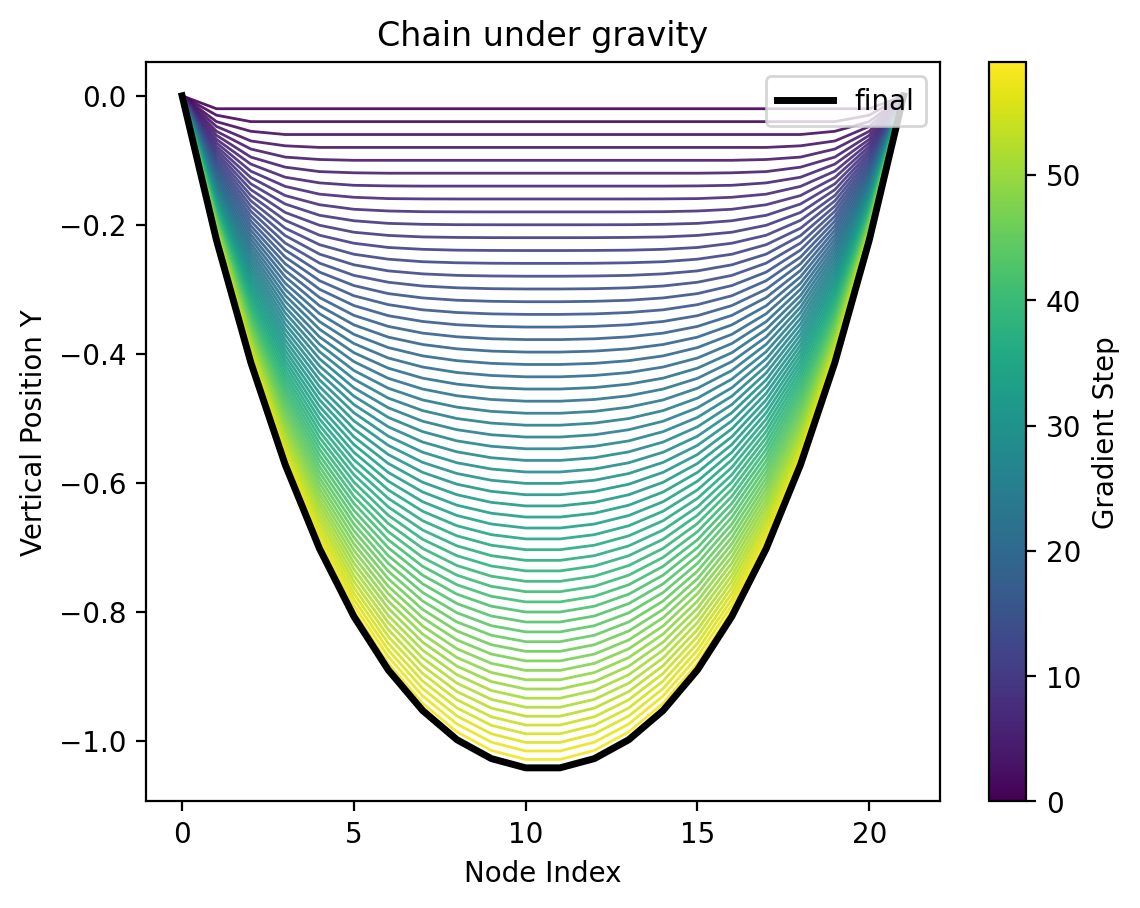

In [5]:
# Now do several steps of gradient descent:

nsteps = 60
eta = 0.2
zero = jnp.array([0.0]) #needed to add the fixed endpoints to the plot

fig, ax = plt.subplots()

# setup a colormap
cmap = plt.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=nsteps-1)

# plot each step in its own color
for step in range(nsteps):
    y -= eta * grad_E(y, spring, length, mass_g)
    ax.plot(
        jnp.concatenate([zero, y, zero]),
        color=cmap(norm(step)),
        linewidth=1,
        alpha=0.9,
    )

# highlight final shape
ax.plot(jnp.concatenate([zero, y, zero]),
        color="black", linewidth=2.5, label="final")

# create a ScalarMappable just for the colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax)   
cbar.set_label("Gradient Step")

ax.set_xlabel("Node Index")
ax.set_ylabel("Vertical Position Y")
ax.set_title("Chain under gravity")
ax.legend(loc="upper right")

plt.show()

This sort of manual gradient descent is common but not nessecary. Prebuilt packages already exist for doing more sophisticated gradient descents. This lesson suggest using optax and using the adam optimizer. 

In [6]:
import optax

In [7]:
# Initialization:
y = jnp.zeros(N) # initially, all masses at y=0

# the gradient step size is called "learning rate"
# in machine learning language:
learning_rate = 0.1

# get the optimizer:
optimizer = optax.adam( learning_rate )
# initialize the 'state' of the optimizer, by
# telling it about the initial values:
opt_state = optimizer.init( y )

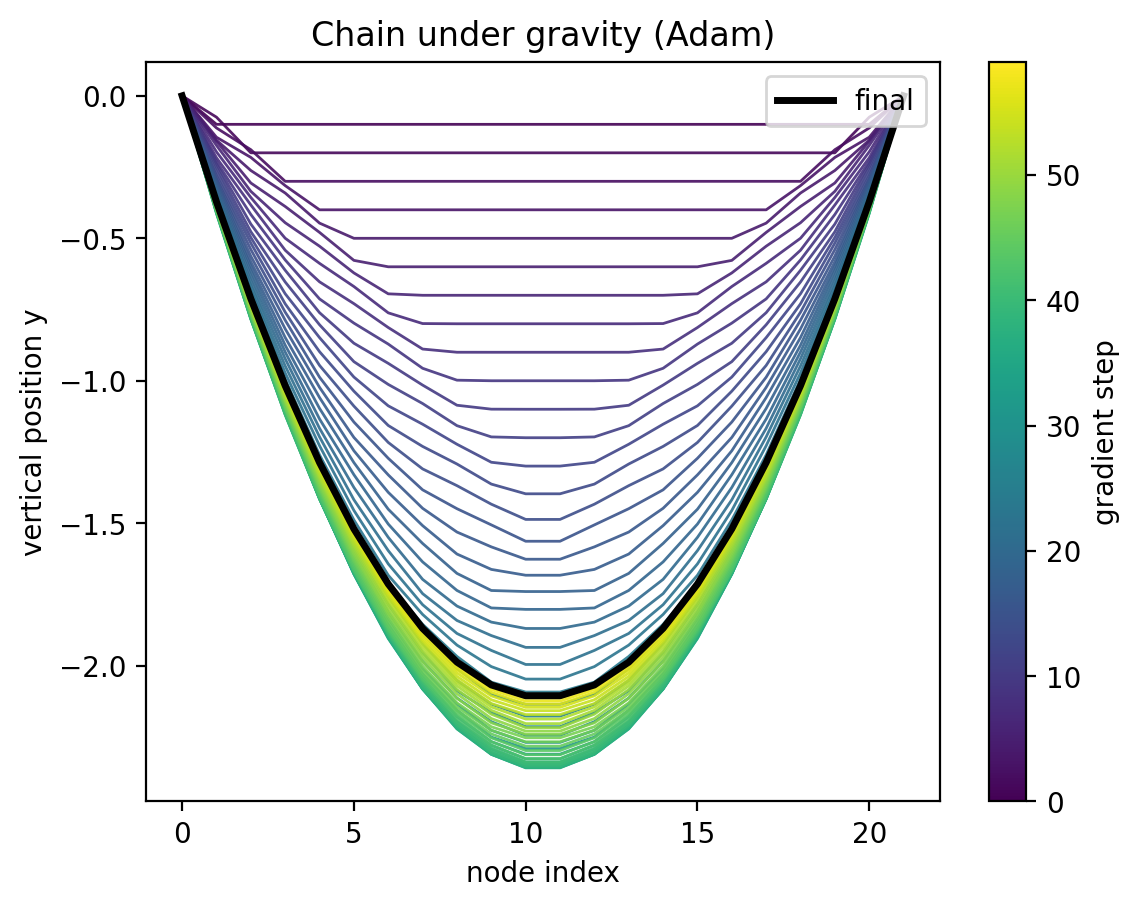

In [ ]:
# Init
y = jnp.zeros(N)
learning_rate = 0.1
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(y)

nsteps = 60
zero = jnp.array([0.0])

fig, ax = plt.subplots()

# colormap setup
cmap = plt.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=nsteps-1)

for step in range(nsteps):
    grads = grad_E(y, spring, length, mass_g)
    updates, opt_state = optimizer.update(grads, opt_state, params=y)
    y = optax.apply_updates(y, updates)

    ax.plot(jnp.concatenate([zero, y, zero]),
            color=cmap(norm(step)), linewidth=1, alpha=0.9)

# highlight final
ax.plot(jnp.concatenate([zero, y, zero]),
        color='black', linewidth=2.5, label='final')

# colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Gradient Step')

ax.set_xlabel('Node Index')
ax.set_ylabel('Vertical Position Y')
ax.set_title('Chain under gravity (Adam)')
ax.legend(loc='upper right')
plt.show()

That marks the end of Lesson 1. If desired, experiment with different constants to see how different the end results ends up being. The spring legth provides interesting results for 1 and above, meaning that the spring is are either fully stable when the chain is fully stretched or the springs still aren't fully relaxed when the chain is fully stretched. 
